## Canine GWAS Target Sample Selection

Steps:
    
- Merge reference and target datasets
- Filter to autosomes
- Run PCA on the merged dataset filtered to reference samples
- Project all target samples onto the reference PCA space
- Select target samples in the neighborhood of homogeneous labeled populations (in the reference set)

In [2]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.express as px
import plotly.graph_objects as go
import os.path as osp
from IPython.display import display, Image
%run ../../nb.py
%run paths.py
%run common.py
%run utils.py # PCA routines with out-of-sample projection (from macarthurlab)
gab.register_timeop_magic(get_ipython(), 'hail')
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://d40dbc6dadcd:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200213-2135-0.2.30-2ae07d872f43.log


### Load Target and Reference Data

In [3]:
%%capture
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

In [4]:
mt_ref = hl.read_matrix_table(osp.join(WORK_DIR, REF_QC_03_FILE + '.mt'))
mt_ref = mt_ref.drop('pcs')
mt_ref = mt_ref.annotate_cols(source='ref')
mt_ref = mt_ref.key_cols_by('source', 's')
mt_ref.count()

(36332, 1350)

In [5]:
mt_tgt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_TGT_DIR, PLINK_FILE_TGT),
    skip_invalid_loci=False,
    reference_genome='canine'
)
mt_tgt = mt_tgt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
mt_tgt = mt_tgt.annotate_cols(source='tgt')
mt_tgt = mt_tgt.key_cols_by('source', 's')
mt_tgt.count()

2020-02-13 21:35:40 Hail: INFO: Found 4342 samples in fam file.
2020-02-13 21:35:40 Hail: INFO: Found 160727 variants in bim file.
2020-02-13 21:35:41 Hail: INFO: Coerced sorted dataset


(160727, 4342)

### Merge Datasets

In [6]:
# Resolve minor schema conflicts
def prep_ref(mt):
    mt = mt.drop('pcs')
    return mt.key_cols_by('source', 's')

def prep_tgt(mt):
    mt = mt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
    return mt.key_cols_by('source', 's')
    
# Concatenate along sample axis, joining to only shared variants (by locus and allele)
mt = mt_ref.union_cols(mt_tgt, row_join_type='inner')

# After the merge, there should be as many variants left as there
# were originally in the reference dataset
assert mt.count()[0] == mt_ref.count()[0]

# Filter to autosomes (which means chrosome 1-38 for dogs)
mt = mt.filter_rows(hl.int(mt.locus.contig) <= 38)
mt.count()

2020-02-13 21:35:43 Hail: INFO: Coerced sorted dataset
2020-02-13 21:35:44 Hail: INFO: Coerced sorted dataset


(36332, 5692)

### PCA

In [7]:
%run utils.py # PCA routines with out-of-sample projection (from macarthurlab)

In [8]:
pc_evals_ref, pc_scores_ref, pc_loadings_ref = run_pca_with_relateds(
    mt.filter_cols(mt.source=='ref'), None, n_pcs=10
)

2020-02-13 21:35:48 Hail: INFO: Coerced sorted dataset
2020-02-13 21:36:00 Hail: INFO: hwe_normalized_pca: running PCA using 36332 variants.
2020-02-13 21:36:01 Hail: INFO: Coerced sorted dataset
2020-02-13 21:36:13 Hail: INFO: pca: running PCA with 10 components...
2020-02-13 21:36:40 Hail: INFO: Coerced sorted dataset


In [9]:
pc_scores_tgt = pc_project(mt.filter_cols(mt.source=='tgt'), pc_loadings_ref)

2020-02-13 21:36:41 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'


In [10]:
assert pc_scores_ref.count() + pc_scores_tgt.count() == mt.count()[1]

2020-02-13 21:36:41 Hail: INFO: Coerced sorted dataset
2020-02-13 21:36:42 Hail: INFO: Coerced sorted dataset


#### Loadings

This will attempt to recreate loadings visualizations as shown in [bigsnpr/how-to-PCA](https://privefl.github.io/bigsnpr/articles/how-to-PCA.html).

In [65]:
pc_loadings_ref.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'locus': locus<canine> 
    'alleles': array<str> 
    'loadings': array<float64> 
    'pca_af': float64 
----------------------------------------
Key: ['locus', 'alleles']
----------------------------------------


In [66]:
# Extract the loadings
df = pc_loadings_ref.key_by().select('loadings').to_pandas()
df = pd.DataFrame(df['loadings'].tolist()).reset_index(drop=True)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.004944,0.000127,0.003689,0.005878,0.002561,-0.006854,0.007231,-0.005338,0.010129,-0.004204
1,-0.000865,-0.002492,-0.002600,-0.007732,0.002547,0.008508,-0.005022,-0.004626,0.008764,0.007107
2,0.004390,-0.002352,-0.003084,-0.009814,0.002849,0.002525,0.006200,0.003167,0.001873,0.007754
3,0.001996,0.002390,0.001561,0.004809,-0.002319,0.002035,0.009674,0.000452,0.003980,0.006156
4,0.009564,0.006623,-0.000158,0.005032,-0.000256,0.000069,0.003916,-0.002403,-0.000133,-0.001034


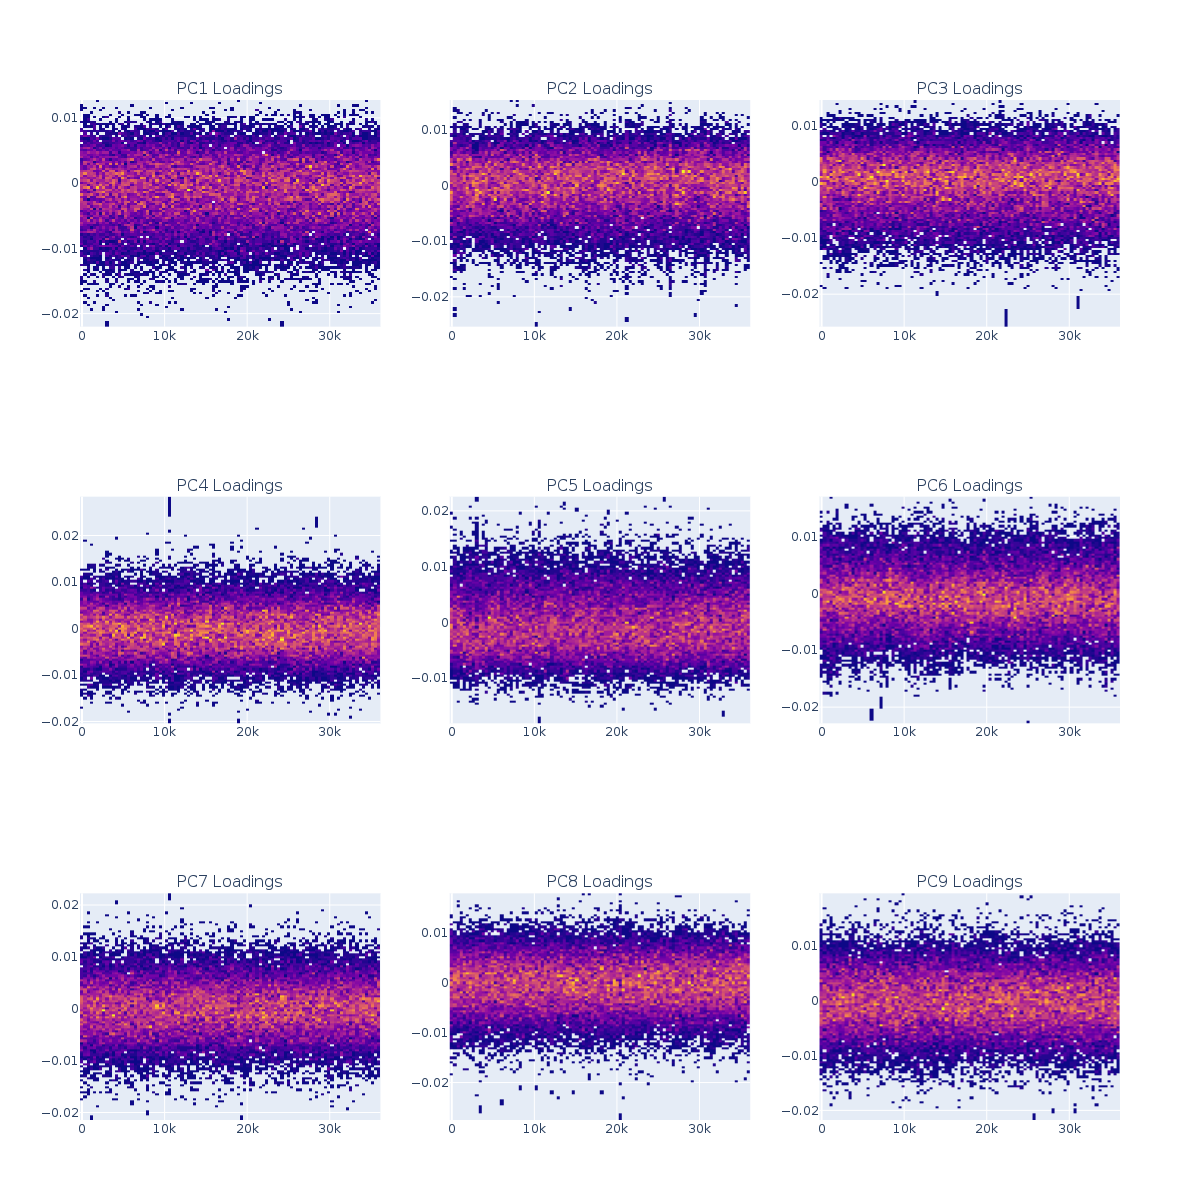

In [67]:
from plotly.subplots import make_subplots

def get_traces(df):
    # Stack loadings into long form
    df = df.rename_axis('pc', axis='columns').rename_axis('idx', axis='index')\
        .stack().rename('value').reset_index()
    traces = {}
    
    # Group by pc and compute binned variant index and loading value counts (we do not want
    # to provide directly to Histogram2D or something of the like since it is too much data)
    for k, g in df.groupby('pc'):
        g = pd.DataFrame(dict(
            value=[b.left for b in pd.cut(g['value'], bins=96)],
            idx=[b.left for b in pd.cut(g['idx'], bins=96)]
        )).groupby(['value', 'idx']).size().rename('count').reset_index()
        traces[k] = go.Heatmap(x=g['idx'], y=g['value'], z=g['count'], showscale=False)
    return traces

traces = get_traces(df)
n_pcs = 9
fig = make_subplots(rows=3, cols=3, subplot_titles=[f'PC{pc+1} Loadings' for pc in range(n_pcs)])
for pc in range(n_pcs):
    row, col = pc // 3, pc % 3
    fig.add_trace(traces[pc], row=row+1, col=col+1)
Image(fig.to_image('png', width=1200, height=1200))

TODO: Should this be used to remove SNPs with high loadings? There are a few that standout.

Add breed info to pca scores for reference data:

In [43]:
pc_scores_ref = pc_scores_ref.annotate(
    breed=mt_ref.cols()[pc_scores_ref.key].breed,
    breed_name=mt_ref.cols()[pc_scores_ref.key].breed_name,
    breed_clade=mt_ref.cols()[pc_scores_ref.key].breed_clade
)

Visualize:

In [44]:
df = pd.concat([
    pc_scores_ref.select(
        PC1=pc_scores_ref.scores[0], PC2=pc_scores_ref.scores[1], 
        breed=pc_scores_ref.breed,
        breed_name=pc_scores_ref.breed_name,
        breed_clade=pc_scores_ref.breed_clade
    ).to_pandas(),
    pc_scores_tgt.select(PC1=pc_scores_tgt.scores[0], PC2=pc_scores_tgt.scores[1]).to_pandas()
], sort=True)
df

2020-02-13 22:14:59 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-13 22:14:59 Hail: INFO: Coerced sorted dataset
2020-02-13 22:14:59 Hail: INFO: Coerced sorted dataset
2020-02-13 22:14:59 Hail: INFO: Coerced sorted dataset
2020-02-13 22:15:00 Hail: INFO: Coerced sorted dataset
2020-02-13 22:15:01 Hail: INFO: Coerced sorted dataset
2020-02-13 22:15:32 Hail: INFO: Coerced sorted dataset
2020-02-13 22:15:32 Hail: INFO: Coerced sorted dataset


,PC1,PC2,breed,breed_clade,breed_name,s,source
0,0.069806,0.127812,ACKR,Spaniel,American Cocker Spaniel,ACKR_09007,ref
1,0.056027,0.119430,ACKR,Spaniel,American Cocker Spaniel,ACKR_09030,ref
2,0.067480,0.118846,ACKR,Spaniel,American Cocker Spaniel,ACKR_09032,ref
3,0.059429,0.124184,ACKR,Spaniel,American Cocker Spaniel,ACKR_09110,ref
4,0.050433,0.134412,ACKR,Spaniel,American Cocker Spaniel,ACKR_09991,ref
...,...,...,...,...,...,...,...
4337,0.037342,0.099134,NaN,NaN,NaN,Wei_GT420,tgt
4338,0.044805,0.099170,NaN,NaN,NaN,Wei_GT421,tgt
4339,0.035003,0.111565,NaN,NaN,NaN,Wei_GT422,tgt
4340,0.039574,0.104670,NaN,NaN,NaN,Wei_GT423,tgt


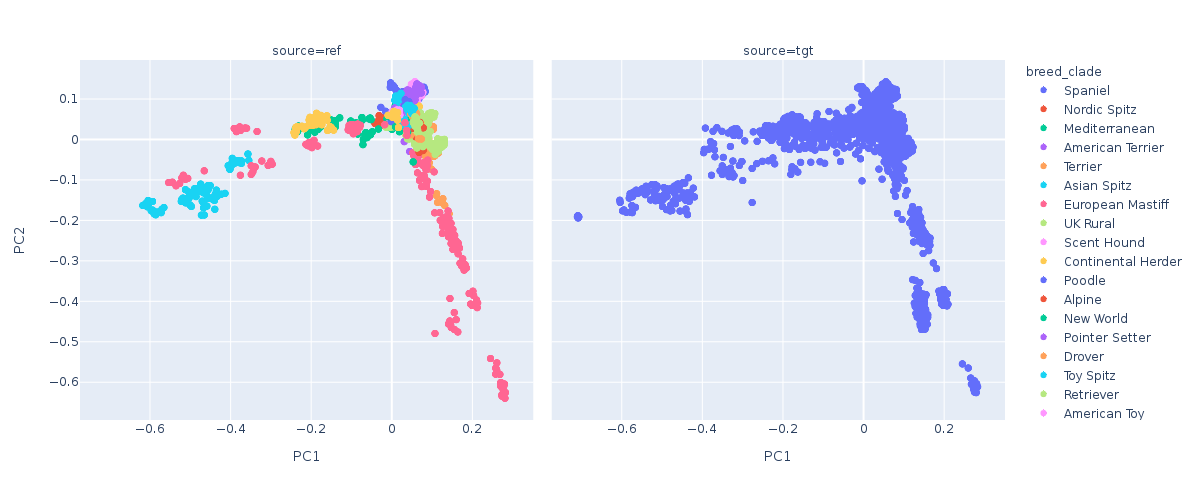

In [45]:
fig = px.scatter(
    df.fillna('NA'),
    x='PC1',
    y='PC2',
    color='breed_clade',
    facet_col='source'
)
#fig.show()
Image(fig.to_image('png', width=1200, height=500))